In [1]:
%matplotlib notebook

%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import sys

import os



import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm
from PIPELINE.convenience_functions import show_image

from astropy.utils.data import get_pkg_data_filename
from astropy.table import Table
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import importlib

pd.options.display.max_rows = 500

import ccdproc


from scipy.ndimage import gaussian_filter1d
import scipy.stats as stats
import scipy

import math


from itertools import groupby

from PIL import Image as P

#general os
import os
import zipfile
import urllib.request

#general plotting
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon


params={'legend.fontsize':'18','axes.labelsize':'18',
        'axes.titlesize':'18','xtick.labelsize':'18',
        'ytick.labelsize':'18','lines.linewidth':2,'axes.linewidth':2,'animation.html': 'html5'}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

#table/math handling
import pandas as pd
import numpy as np
np.seterr(all='ignore')  # hides irrelevant warnings about divide-by-zero, etc

#astropy
import astropy
import astropy.units as u
from astropy.table import QTable
from astropy.io import fits,ascii
from astropy.nddata import StdDevUncertainty
from astropy.modeling import models, fitting
from astropy.visualization import quantity_support,astropy_mpl_style, simple_norm
from astropy import constants as const
from astropy.stats import mad_std
from astropy.nddata import CCDData
from astropy.visualization import hist
from PIPELINE.convenience_functions import show_image, display_cosmic_rays

#specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import gaussian_smooth
from specutils.fitting import fit_generic_continuum
from specutils.fitting import find_lines_derivative
from specutils.fitting import find_lines_threshold
from specutils.fitting import fit_lines
from specutils.manipulation import noise_region_uncertainty
from specutils.analysis import centroid
from specutils.analysis import line_flux
from specutils.analysis import equivalent_width
from specutils.analysis import template_comparison

quantity_support();  # auto-recognizes units on matplotlib plots

from ipywidgets import interact
import ipywidgets as widgets

In [3]:

def trim_raw_dir(goodman_files):
    remove_list = []
    for img in goodman_files.files:
        img_path = os.path.join(raw_goodman_path,img)
        ccd = CCDData.read(img_path,unit='adu')

        old_slit_val = ccd.header['slit']
        new_slit_val = old_slit_val.replace('"','').replace(' ','_').upper()

        old_grating_val = ccd.header['grating'].split('_')

        if old_grating_val[0]=='SYZY':
            new_grating_val = old_grating_val[1]+'_'+old_grating_val[0]
            ccd.header['grating'] = new_grating_val

        old_wavmode_val = ccd.header['wavmode']
        new_wavmode_val = old_wavmode_val.replace(' ','_').upper()


        ccd.header['slit'] = new_slit_val

        ccd.header['wavmode'] = new_wavmode_val

        if new_wavmode_val=="ZZ_CETI_RED":
            remove_list.append(img_path)
        if new_slit_val!="1.0_LONG_SLIT":
            #print(img,new_slit_val)
            remove_list.append(img_path)

        ccd.write(Path(raw_goodman_path) / img,overwrite=True)

    for im in remove_list:
        try:
            pass
            #os.remove(im)
        except:
            pass

        
columns = ['grating_freq', 'wavmode', 'camtarg', 'grttarg', 'ob_filter']
spec_mode = [['400', 'm1', '11.6', '5.8', 'None'],
             ['400', 'm2', '16.1', '7.5', 'GG455'],
             ['600', 'UV', '15.25', '7.0', 'None'],
             ['600', 'Blue', '17.0', '7.0', 'None'],
             ['600', 'Mid', '20.0', '10.0', 'GG385'],
             ['600', 'Red', '27.0', '12.0', 'GG495'],
             ['930', 'm1', '20.6', '10.3', 'None'],
             ['930', 'm2', '25.2', '12.6', 'None'],
             ['930', 'm3', '29.9', '15.0', 'GG385'],
             ['930', 'm4', '34.6', '18.3', 'GG495'],
             ['930', 'm5', '39.4', '19.7', 'GG495'],
             ['930', 'm6', '44.2', '22.1', 'OG570'],
             ['1200', 'm0', '26.0', '16.3', 'None'],
             ['1200', 'm1', '29.5', '16.3', 'None'],
             ['1200', 'm2', '34.4', '18.7', 'None'],
             ['1200', 'm3', '39.4', '20.2', 'None'],
             ['1200', 'm4', '44.4', '22.2', 'GG455'],
             ['1200', 'm5', '49.6', '24.8', 'GG455'],
             ['1200', 'm6', '54.8', '27.4', 'GG495'],
             ['1200', 'm7', '60.2', '30.1', 'OG570'],
             ['1800', 'Custom', 'None', 'None', 'None'],
             ['2100', 'Custom', 'None', 'None', 'None'],
             ['2400', 'Custom', 'None', 'None', 'None']
             ]

readout_columns = ['camera', 'rate', 'ATTN', 'gain', 'rdnoise']
readout_configs = [['Blue', '50kHz', '0', '0.25', '3.33'],
                   ['Blue', '50kHz', '2', '0.47', '3.35'],
                   ['Blue', '50kHz', '3', '0.91', '3.41'],
                   ['Blue', '100kHz', '0', '0.56', '3.69'],
                   ['Blue', '100kHz', '2', '1.06', '3.72'],
                   ['Blue', '100kHz', '3', '2.06', '3.99'],
                   ['Blue', '200kHz', '0', '1.4', '4.74'],
                   ['Blue', '200kHz', '2', '2.67', '5.12'],
                   ['Blue', '400kHz', '0', '5.67', '8.62'],
                   ['Red', '100kHz', '3', '1.54', '3.45'],
                   ['Red', '100kHz', '2', '3.48', '5.88'],
                   ['Red', '344kHz', '3', '1.48', '3.89'],
                   ['Red', '344kHz', '0', '3.87', '7.05'],
                   ['Red', '344kHz', '2', '1.47', '5.27'],
                   ['Red', '344kHz', '0', '3.77', '8.99']
]
rd_df = pd.DataFrame(np.asarray(readout_configs),columns=readout_columns)

specm_df = pd.DataFrame(data=np.asarray(spec_mode),columns=columns)

def create_wavmode_instconf(files,raw_goodman_path):
    
    for img in files.files:
        img_path = os.path.join(raw_goodman_path,img)
        ccd = CCDData.read(img_path,unit='adu')

        full_grt = ccd.header['grating'].split("_")
        print(img,full_grt)
        
        try:
            if full_grt[0].isdigit():
                grt = full_grt[0]
                grt_nam = full_grt[1]
            elif full_grt[1].isdigit():
                grt = str(full_grt[1])
                grt_nam = full_grt[0]

            new_grating_val = "_".join((grt,grt_nam.upper()))
        except:
            new_grating_val = full_grt[0]


        camtarg = str(ccd.header['cam_targ'])
        grttarg = str(ccd.header['grt_targ'])
        filt = str(ccd.header['filter2'])
        
        ccdsum1,ccdsum2 = ccd.header['ccdsum'].split(" ")
        roi = "Spectroscopic %sx%s"%(ccdsum1,ccdsum2)
        gain = str(ccd.header['gain'])
        rdnoise = str(ccd.header['rdnoise'])

        wvheadlist, = np.where((specm_df['grttarg']==grttarg) & (specm_df['camtarg']==camtarg) & \
                            (specm_df['grating_freq']==grt) & (specm_df['ob_filter']==filt))

        icheadlist, = np.where((rd_df['gain']==gain) & (rd_df['rdnoise']==rdnoise))

        wavmode = "_".join((grt,specm_df.loc[wvheadlist[0],'wavmode'].upper()))
        #print(wavmode,new_grating_val)
        instconf = rd_df.loc[icheadlist[0],'camera']

        ccd.header['grating'] = new_grating_val
        ccd.header['instconf'] = instconf
        ccd.header['wavmode'] = wavmode
        ccd.header['roi'] = roi

        ccd.write(Path(raw_goodman_path) / img,overwrite=True)

#create_wavmode_instconf(goodman_files,raw_goodman_path)


In [5]:
raw_goodman_path = "/Users/danakoeppe/PipelineProjects/GOODMAN_raw_data/"





procdir = "goodman_test_products"
if os.path.exists("goodman_test_products"):
    try:
        for f in os.listdir("goodman_test_products"):
            os.remove(os.path.join(procdir,f))
    except:
        pass
else:
    os.mkdir("goodman_test_products")
    
goodman_files =  ccdp.ImageFileCollection(raw_goodman_path)

goodman_summary = goodman_files.summary.to_pandas()

norm_mflat = CCDData.read("./processed/norm_master_flat_400 m2_GG455_01-2-0000.fits")
mflat = CCDData.read("./processed/master_flat_400 m2_GG455_01-2-0000.fits")


raw_gdm_ori = goodman_summary.file.iloc[30]
uncropped_ori_ccd = CCDData.read(raw_goodman_path+raw_gdm_ori)

raw_gdm_flt = goodman_summary.file.iloc[2]
uncropped_fri_ccd = CCDData.read(raw_goodman_path+raw_gdm_flt)

trimsec = '[30:4110,400:1600]'#uncropped_fri_ccd.header['trimsec']
fits_sec_x,fits_sec_y = trimsec.strip("'[").strip("]'").split(",")

fri_ccd = ccdp.trim_image(ccd=uncropped_fri_ccd, add_keyword=True,fits_section=trimsec)
ori_ccd = ccdp.trim_image(ccd=uncropped_ori_ccd,add_keyword=True,fits_section=trimsec)





raw_gdm_cri = goodman_summary.file.iloc[33]
cri_ccd = CCDData.read(raw_goodman_path+raw_gdm_cri)


readout_configurations = goodman_files.summary.to_pandas().groupby(
            ['gain',
             'rdnoise',
             'ccdsum',
             'filter2',
             'slit',
             'grating']).size().reset_index().rename(columns={0: 'count'})

goodman_summary.where(goodman_summary.grating=='400_SYZY').dropna(how='all')

,file,simple,bitpix,naxis,naxis1,naxis2,date-obs,date,time,n_param,...,checksum,datasum,odtacqnm,bunit,instconf,wavmode,roi,bscale,bzero,comment
0,psg_140319_210352_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:03:52.430,2014-03-19,21:03:52.43 to 21:03:54.76,80.0,...,C5o2C2m2C2m2C2m2,3847477586,/user/observer/today/0039.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"
1,psg_140319_210620_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:06:20.720,2014-03-19,21:06:20.72 to 21:06:22.98,80.0,...,cAGAe097c7GAc795,116232393,/user/observer/today/0040.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"
2,psg_140319_210744_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:07:44.260,2014-03-19,21:07:44.26 to 21:07:46.58,80.0,...,9c4ABZ129b19AZ19,1225891669,/user/observer/today/0041.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"
3,psg_140319_210907_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:09:07.800,2014-03-19,21:09:07.80 to 21:09:10.11,80.0,...,6eZ38eY06eY06eY0,1151317876,/user/observer/today/0042.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"
4,psg_140319_211031_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:10:31.350,2014-03-19,21:10:31.35 to 21:10:33.67,80.0,...,5QnEAOk95OkEAOk9,1900782187,/user/observer/today/0043.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"
5,psg_140319_211154_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:11:54.890,2014-03-19,21:11:54.89 to 21:11:57.18,80.0,...,4jpT7goT4goT4goT,641158274,/user/observer/today/0044.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"
6,psg_140319_211318_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:13:18.510,2014-03-19,21:13:18.51 to 21:13:20.84,80.0,...,9iAjBi8i9iAiAi5i,939580752,/user/observer/today/0045.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"
7,psg_140319_211442_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:14:42.320,2014-03-19,21:14:42.32 to 21:14:44.60,80.0,...,mKbXpHZXmHaXmHYX,3028430750,/user/observer/today/0046.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"
8,psg_140319_211605_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:16:05.840,2014-03-19,21:16:05.84 to 21:16:08.15,80.0,...,lCRdo9OZlAOdl9OZ,3534621335,/user/observer/today/0047.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"
9,psg_140319_211729_fri.fits,1.0,16.0,2.0,4142.0,1896.0,2014-03-19T21:17:29.430,2014-03-19,21:17:29.43 to 21:17:31.73,80.0,...,YEoAbCo5ZCoAaCo3,2888010206,/user/observer/today/0048.qflat_400m2_GG455.fits,adu,Blue,400_M2,Spectroscopic 1x1,1.0,32768.0,"Triggered Acquisition, Exp Time= 02"


In [6]:
trimsec = fri_ccd.header['trimsec']
fits_sec_x,fits_sec_y = trimsec.strip("'[").strip("]'").split(",")

print(fits_sec_x,fits_sec_y)
tfri_ccd = ccdp.trim_image(ccd=fri_ccd, add_keyword=True,fits_section=trimsec)
readout_configurations

30:4110 1:1896


,gain,rdnoise,ccdsum,filter2,slit,grating,count
0,2.06,3.99,1 1,GG455,Ori0B1-field2-0000R,400_SYZY,24
1,2.06,3.99,1 1,GG455,Ori0B1-field2-0000R,<NO GRATING>,20


In [7]:

spec1d = Spectrum1D.read("/Users/danakoeppe/Downloads/spec-56966-HD052428S022349V01_sp13-206.fits",
                         format="wcs1d-fits")



spec1d

<Spectrum1D(flux=<Quantity [[ 2.1872261e+01, -1.8780469e+02, -3.4152676e+02, ...,
             5.0570244e+01,  5.7118088e+01,  5.3163288e+01],
           [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
             6.2247366e-03,  7.1530612e-03,  7.0367795e-03],
           [ 3.6999863e+03,  3.7008384e+03,  3.7016907e+03, ...,
             9.0949453e+03,  9.0970400e+03,  9.0991348e+03],
           [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
             0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
           [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
             0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]>, spectral_axis=<SpectralAxis [3.5682, 3.5683, 3.5684, ..., 3.9588, 3.9589, 3.959 ] pix>)>

<IPython.core.display.Javascript object>


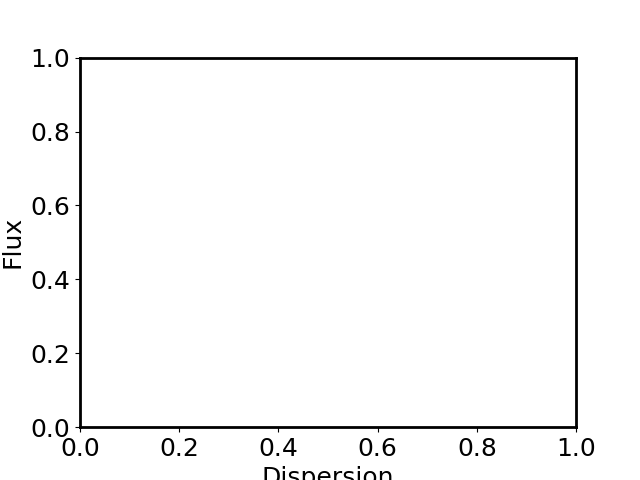

Text(0, 0.5, 'Flux')

In [8]:
ax = plt.subplots()[1]  

#ax.plot(spec1d.spectral_axis, spec1d.flux)  

ax.set_xlabel("Dispersion")  

ax.set_ylabel("Flux") 

<IPython.core.display.Javascript object>


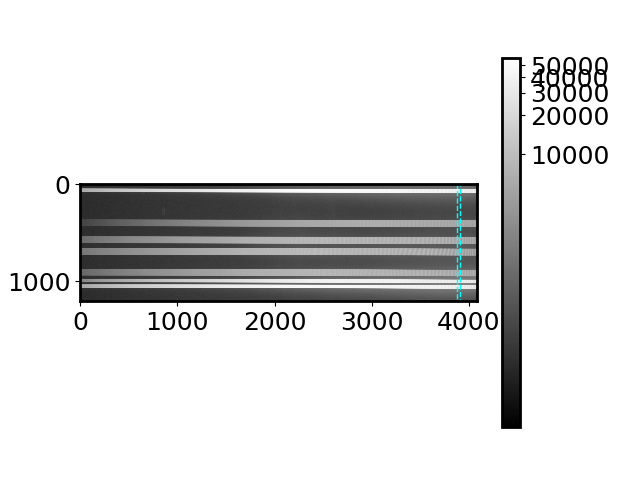

Rectangle(xy=(3876, 0), width=30, height=1201, angle=0)


3876

In [9]:




fig1 = plt.figure()
ax1 = fig1.add_subplot(111)



sx, sy, sw, sh = int(3.8*(fri_ccd.shape[1]//4)), 0,30,fri_ccd.shape[0]
col = sx

#ax1.imshow(fri_ccd,cmap='gray',origin='lower')

slice_rectangle = Rectangle((sx, sy), sw, sh, facecolor='none', edgecolor='cyan', linestyle='--',lw=1.)


er_norm = simple_norm(fri_ccd, stretch='log')

img3 = ax1.imshow(fri_ccd, cmap='gray', 
                  norm=er_norm, interpolation='none')
clb3 = fig1.colorbar(img3)

ax1.add_patch(p=slice_rectangle)
print(slice_rectangle)
int(3.8*fri_ccd.shape[1]//4)

131.86813134501148
[  49   84  365  435  538  608  656  726  872  940  974 1009 1031 1066]
131.86813134501148
[  49   84  365  435  538  608  656  726  872  940  974 1009 1031 1066]
190.70898166182886
[  51   86  367  437  540  610  658  728  874  942  976 1011 1033 1068]
197.909838670966
[  53   88  369  439  543  613  661  731  877  944  979 1014 1035 1071]
173.75250674877523
[  54   89  371  441  545  615  663  733  879  947  981 1017 1038 1074]
162.31404941834063
[  54   90  371  441  545  615  663  734  880  948  982 1017 1039 1075]


<IPython.core.display.Javascript object>


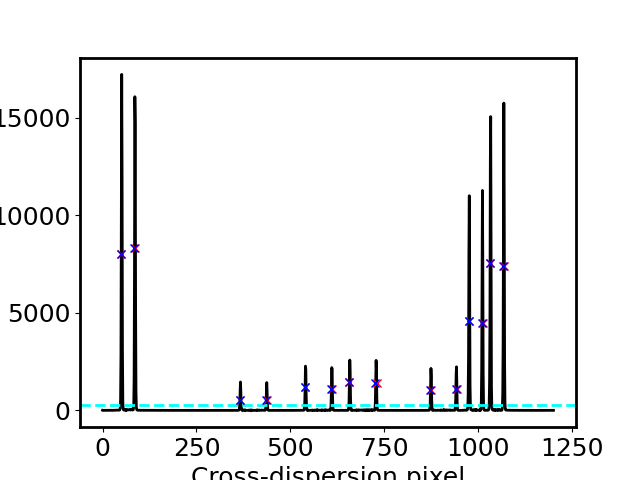

In [22]:
def slice_coadd(col_idx,width,er_width,extractregdata):

    half_width = width // 2
    to_coadd = np.arange(max(0, col_idx - half_width), 
                     min(er_width-1, col_idx + half_width))
    #print(max(0, col_idx - half_width),min(er_width-1, col_idx + half_width))
    #print(to_coadd.shape)
    return extractregdata[:, to_coadd].sum(axis=1) / width



def trace_slit_edges_with_coadd(input_ccd,col=col, slice_width=30, guass_smooth_std=8,num_slits=7):
    
    
    min_peaks = num_slits*2
    
    if (col+slice_width)>input_ccd.shape[1]:
        col = input_ccd.shape[1]-slice_width-1
    
    sx, sy, sw, sh = col, 0, slice_width, input_ccd.shape[0]
    
    
        
        
    #starting col, starting row, slice width, slice height
    #slice_rectangle = Rectangle((sx, sy), sw, sh, facecolor='none', edgecolor='cyan', linestyle='--',lw=1.)

    x,y = sx, sy    #slice_rectangle.xy
    w = sw          #slice_rectangle.get_width() 
    h = sh          #slice_rectangle.get_height() 


    slice_er_y, slice_er_x = np.mgrid[y:y+h, x:x+w]
    extract_slice = input_ccd.data[slice_er_y, slice_er_x]
    extract_slice_shape = extract_slice.shape
    slice_xpix = np.arange(h)#np.arange(extract_slice_shape[0])

    coadded = slice_coadd(x,w,input_ccd.data.shape[1],input_ccd.data)

    #dp_coadd = np.gradient(np.gradient(coadded)) # second derivative of coadded signal to get inflection points
    dp_coadd = np.abs(np.gradient(coadded))
    slice_1 = smooth = gaussian_filter1d(coadded, guass_smooth_std)
    slice_xpix = slice_xpix
    
    mean, var = stats.norm.fit(dp_coadd)
    std = np.sqrt(var)
    
    # below loop identifies slit edges from inflection points by taking the column index where 
    # changes are largest.  To avoid multiple columns around the same value, the loop makes sure
    # that every subsequent saved column index is more than 5 steps away from the previous saved
    # value.  

    big_peaks = []
    last_big_peak_col = None
    slit_pairs = []
    slit_pair = []
    
    
    peaks = scipy.signal.find_peaks(dp_coadd,height=10*std)[0]
    pkwdths,pkhts,pklfts,pkrts = scipy.signal.peak_widths(peaks=peaks,x=dp_coadd)

    print(5*std)
    print(peaks)
    if len(peaks) % 2 == 0:
        
        ei = 0
        while ei<len(peaks):
            upper_pk_wdth = pkwdths[ei]
            lower_pk_wdth = pkwdths[ei+1]
            
            upper_pk_ind = int(pklfts[ei]-upper_pk_wdth)
            lower_pk_ind = int(pklfts[ei+1]+lower_pk_wdth)
            
            slit_pairs.append([upper_pk_ind, lower_pk_ind])
            ei+=2

    else:
        
        print("Uneven number of peaks in cross dispersion direction.  Check that image is properly trimmed.")

    return slit_pairs, dp_coadd


third_x = fri_ccd.shape[1]//3
quart_x = fri_ccd.shape[1]//4
slice_cols = [quart_x, quart_x*2, quart_x*3, int(quart_x*3.8),fri_ccd.shape[1]]

coadded = slice_coadd(slice_cols[1],30,fri_ccd.data.shape[1],fri_ccd.data)

sps, dp_coadd = trace_slit_edges_with_coadd(fri_ccd, col=slice_cols[0])
mean, var = stats.norm.fit(dp_coadd)
std = np.sqrt(var)

all_pairs = []
center_pairs = None
center_dpc = None
for i in slice_cols:
    #print(i)
    pairs, dpc = trace_slit_edges_with_coadd(fri_ccd,col=i)
    all_pairs.append(np.vstack(pairs))
    #print(pairs)
    center_col = fri_ccd.shape[1]//2
    if i==center_col:
        center_pairs = pairs
        center_dpc = dpc
        
    
    
fig_sl = plt.figure()
fig_sl.clf()
ax_sl = fig_sl.add_subplot(111)

slice_xpix = np.arange(len(dp_coadd))
lin_raw, = ax_sl.plot(slice_xpix,np.abs(np.gradient(coadded)) , 'k-')

ax_sl.axhline(10*std,color='cyan',ls='--')
ax_sl.set_xlabel('Cross-dispersion pixel')
ax_sl.axes.set_ylabel('Coadded signal')

pks, pkprops = scipy.signal.find_peaks(dp_coadd,height=std*10,distance=5)


pkwdths,pkhts,pklfts,pkrts = scipy.signal.peak_widths(peaks=pks,x=dp_coadd)

new_pks_rt = []
new_pks_lft = []
new_pks = []
ei = 0
while ei<len(pks):
    upper_pk_wdth = pkwdths[ei]
    lower_pk_wdth = pkwdths[ei+1]

    upper_pk_ind = int(pkrts[ei])
    lower_pk_ind = int(pkrts[ei+1])

    new_pks.append([upper_pk_ind, lower_pk_ind+lower_pk_wdth])
    ei+=2

new_pks = np.asarray(new_pks)
ax_sl.plot(new_pks.flatten(),dp_coadd[pks],"x",color='red')
ax_sl.plot(pks,dp_coadd[pks],"x",color='blue')

#ax_sl.plot(pkrts-pkwdths,dp_coadd[pks]/2.,"x",color='pink')


In [11]:

pklfts,pkrts

(array([  47.34426799,   82.69122139,  363.50164422,  433.54614611,
         536.98247569,  607.0417156 ,  654.85400737,  724.9322366 ,
         871.0050335 ,  938.55304345,  972.68658341, 1007.94409475,
        1029.57510747, 1064.98383149]),
 array([  49.98593057,   85.36431153,  366.19908427,  436.20009607,
         539.66190874,  609.78680395,  657.56160626,  727.64084931,
         873.75262094,  941.2366361 ,  975.36648625, 1010.59620396,
        1032.266569  , 1067.63715367]))

In [12]:
all_pairs_arr = np.vstack(all_pairs)
#print(all_pairs_arr)
all_pairs_df = pd.DataFrame(data=all_pairs_arr,columns=['y1','y2']).sort_values(by='y1')

all_pairs_df.index = range(len(all_pairs_df))


slit_1 = np.vstack([i[0] for i in all_pairs])
slit_1_xi = np.vstack([slice_cols,slit_1[:,0]]).T
slit_1_xf = np.vstack([slice_cols,slit_1[:,1]]).T

xypoly_1 = np.vstack([slit_1_xi,slit_1_xf])
print([0,slit_1_xi[0][1]],[fri_ccd.shape[1]-1,slit_1_xi[-1][1]])

def make_slit_poly(slice_cols,slit_pairs):
    
    num_vertices = len(slice_cols)*2 
    num_slits = len(slit_pairs[0])
    

    all_slit_vertices = []
    all_slit_polys = []

    for j in range(num_slits):
        this_slit = []
        top_verteces = []
        bottom_verteces = []
        for i in range(len(slice_cols)):
            c = slice_cols[i]
            top_bottom_y = slit_pairs[i][j]
            #print(top_bottom_y)
            ty = top_bottom_y[0]
            by = top_bottom_y[1]
            top_verteces.append([c,ty])
            bottom_verteces.append([c,by])
       
        #print(top_verteces[0])
        top_verteces.insert(0, [0, slit_pairs[0][j][0]-6])
        #print(top_verteces)
        top_verts = np.vstack(top_verteces)
        
        bottom_verteces.insert(0,[0,slit_pairs[0][j][1]+6])
        bott_verts = np.vstack(bottom_verteces)
        slit_vertices = np.vstack([top_verts,bott_verts[::-1]])

        all_slit_vertices.append(slit_vertices)
        
        slit_poly = Polygon(slit_vertices,closed=True, facecolor='none', edgecolor='cyan', linestyle='--',lw=1.)
        all_slit_polys.append(slit_poly)
        
    return all_slit_vertices, all_slit_polys




[0, 44] [4080, 50]


<IPython.core.display.Javascript object>


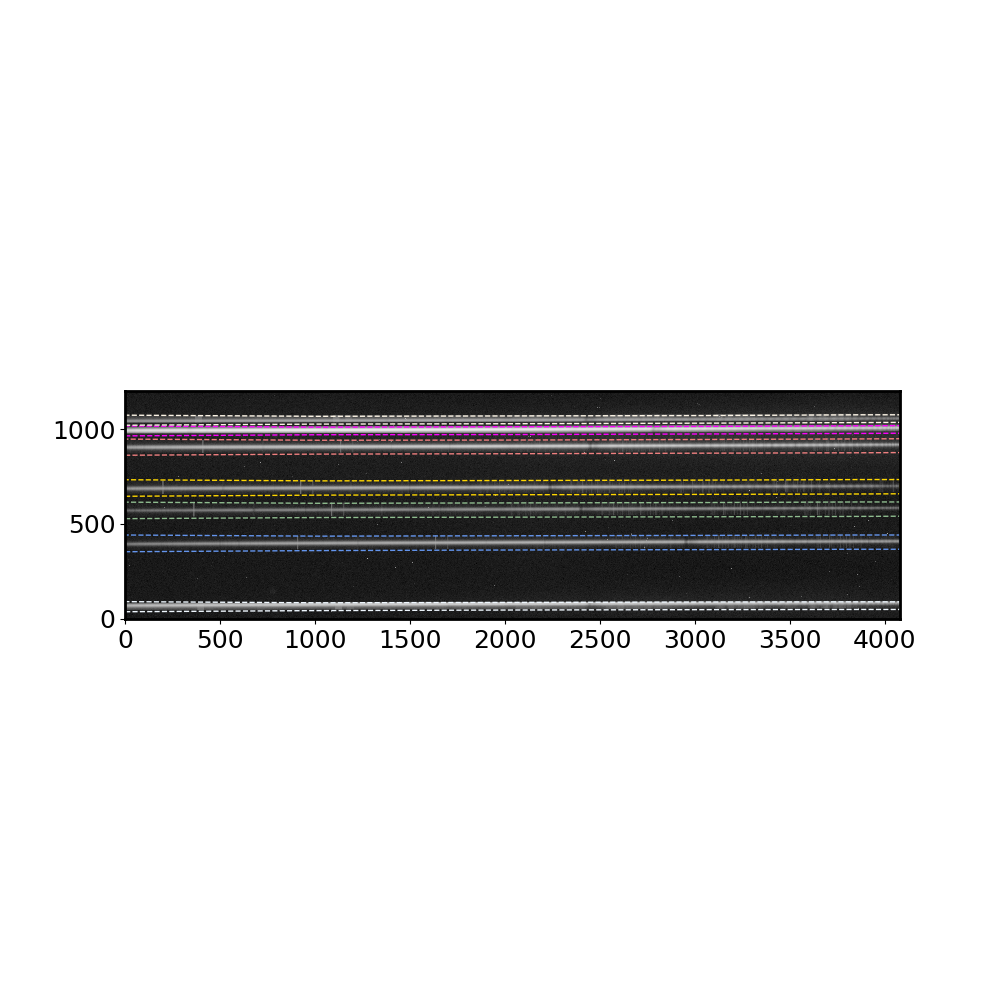

In [21]:
all_slit_vertices, all_slit_polys = make_slit_poly(slice_cols=slice_cols,slit_pairs=all_pairs)
    
all_slit_vertices1,all_slit_polys1 = make_slit_poly(slice_cols=slice_cols,slit_pairs=all_pairs)


fig_poly = plt.figure(figsize=(10,10))
fig_poly.clf()
#ax_poly = fig_poly.add_subplot(121)
ax_opoly = fig_poly.add_subplot(111)
fig_poly.subplots_adjust(wspace=0)
#slice_poly = Polygon(all_slit_vertices[0],closed=True, facecolor='none', edgecolor='cyan', linestyle='--',lw=1.)


er_norm = simple_norm(fri_ccd, stretch='log')

#img_poly = ax_poly.imshow(fri_ccd, cmap='gray',
#                  norm=er_norm, interpolation='none')
#ax_poly.set_xlim(right=0,left=fri_ccd.shape[1])


rearr_ori_data = np.vstack([ori_ccd.data[13:,:],ori_ccd.data[:13,:]])
oer_norm = simple_norm(rearr_ori_data, stretch='log')



oimg_poly = ax_opoly.imshow(rearr_ori_data, cmap='gray', 
                  norm=oer_norm, interpolation='none',origin='lower')
#clb_poly = fig_poly.colorbar(img_poly)

#ax_opoly.tick_params(axis='y',labelleft=False,labelright=True)

color_list = list(matplotlib.colors.cnames.keys())[::17]
"""
i = 0
for p in all_slit_polys:
    p.set_color(color_list[i])
    p.set_fill(None)
    ax_poly.add_patch(p=p)
    i+=1
"""  
    
i = 0   
for p in all_slit_polys1:
    p.set_color(color_list[i])
    p.set_fill(None)
    ax_opoly.add_patch(p=p)
    i+=1


In [19]:
import matplotlib

cls = matplotlib.cm.get_cmap('gist_rainbow')
len(list(matplotlib.colors.cnames.keys()))/7

21.142857142857142

In [543]:
import matplotlib.path as mplpath


slice_poly = all_slit_polys[0]
left = np.min(slice_poly.get_verts(), axis=0)
print(left)
right = np.max(slice_poly.get_verts(), axis=0)
x = np.arange(math.ceil(left[0]), math.floor(right[0])+1)
y = np.arange(math.ceil(left[1]), math.floor(right[1])+1)
xv, yv = np.mgrid[:fri_ccd.shape[1],:fri_ccd.shape[0]]#np.meshgrid(x, y, indexing='xy')

points = np.vstack((xv.ravel(),yv.ravel())).T#np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))

path = mplpath.Path(all_slit_vertices[0])#slice_poly.get_path()
mask = path.contains_points(points)
mask.shape = xv.shape


img_mask = mask.reshape(xv.shape).T

img_mask

[-682.00399274  278.81609533]


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [571]:
img_masks = []
xvs,yvs = [],[]
def cutout_slice_from_poly(ccd,slit_polys_list):
    
    cropped_slits_list = []
    hdulist = [fits.PrimaryHDU(ccd.data,ccd.header)]
    new_ccd = ccd.copy()
    for i in range(len(slit_polys_list)):
        slice_poly = slit_polys_list[i]
        left = np.min(slice_poly.get_verts(), axis=0)
        right = np.max(slice_poly.get_verts(), axis=0)
        x = np.arange(math.ceil(left[0]), math.floor(right[0])+1)
        y = np.arange(math.ceil(left[1]), math.floor(right[1])+1)
        xv, yv = np.mgrid[:ccd.shape[1],:ccd.shape[0]]#np.meshgrid(x, y, indexing='xy')
        xvs.append(xv)
        yvs.append(yv)
        points = np.vstack((xv.ravel(),yv.ravel())).T#np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1))))

        path = slice_poly.get_path() #mplpath.Path(all_slit_vertices[0])#slice_poly.get_path()
        mask = path.contains_points(points)
        mask.shape = xv.shape


        img_mask = mask.reshape(xv.shape).T
        img_masks.append(img_mask)
        
        masked_img = ccd.data*img_mask

        mask_inds_y, mask_inds_x = np.where(masked_img>0)

        #cropped_img = masked_img[mask_inds_y.min():mask_inds_y.max()][mask_inds_x.min():mask_inds_x.max()]
        cropped_img = ccd[mask_inds_y.min():mask_inds_y.max()][mask_inds_x.min():mask_inds_x.max()]

        new_ccd.data = cropped_img
        header_comment = "SLIT_{:03n}".format(i)
        new_ccd.header['SLITNUM'] = header_comment
        hdulist.append(fits.ImageHDU(new_ccd.data,new_ccd.header))
        cropped_slits_list.append(cropped_img)
    
    new_hdu = fits.HDUList(hdus=hdulist)
    
    return new_hdu



new_hdu_flat = cutout_slice_from_poly(fri_ccd,all_slit_polys)


corr_ori_ccd = ccdproc.flat_correct(ccd=ori_ccd,flat=fri_ccd)
new_hdu_ori = cutout_slice_from_poly(corr_ori_ccd,all_slit_polys)

data_acq_fname = ori_ccd.header['ODTACQNM'].split('/')[-1]
new_data_acq_fname = 'scrop'+ori_ccd.header['ODTACQNM'].split('/')[-1]

In [573]:
new_pf = Path('./processed1/') / new_data_acq_fname 

new_hdu_ori.writeto(fileobj=new_pf,overwrite=True)

In [554]:
poly2 = all_slit_polys[2]
left = np.min(poly2.get_xy(), axis=0)
right = np.max(poly2.get_xy(), axis=0)
x = np.arange(math.ceil(left[0]), math.floor(right[0]))
y = np.arange(math.ceil(left[1]), math.floor(right[1]))

xv1, yv1 = np.mgrid[:ori_ccd.shape[1],:ori_ccd.shape[0]]#np.meshgrid(x, y, indexing='xy') #
xv2, yv2 = np.mgrid[:ori_ccd.shape[1],:ori_ccd.shape[0]]#np.meshgrid(x, y, indexing='xy')

points1 = np.vstack((xv1.ravel(),yv1.ravel())).T #np.hstack((xv.reshape((-1,1)), yv.reshape((-1,1)))) #
points2 = np.hstack((xv2.reshape((-1,1)), yv2.reshape((-1,1))))

path = poly2.get_path()#mplpath.Path(all_slit_vertices[0])#slice_poly.get_path()

mask1 = path.contains_points(points1)
mask1.shape = xv1.shape

mask2 = path.contains_points(points2)
mask2.shape = xv2.shape

img_mask1 = mask1.reshape(xv1.shape).T
img_mask2 = mask2.reshape(xv2.shape).T

masked_img1 = ori_ccd.data*img_mask1
masked_img2 = ori_ccd.data*img_mask2

mask_inds_y1, mask_inds_x1 = np.where(masked_img1>0)
mask_inds_y2, mask_inds_x2 = np.where(masked_img2>0)

cropped_img1 = masked_img1[mask_inds_y1.min():mask_inds_y1.max()][mask_inds_x1.min():mask_inds_x1.max()]

cropped_img2 = masked_img2[mask_inds_y2.min():mask_inds_y2.max()][mask_inds_x2.min():mask_inds_x2.max()]

crop_ori = ori_ccd[mask_inds_y1.min():mask_inds_y1.max()][mask_inds_x1.min():mask_inds_x1.max()]

cropped_img2,cropped_img1,masked_img1

(array([[725, 733, 732, ...,   0,   0,   0],
        [729, 729, 728, ...,   0,   0,   0],
        [731, 733, 731, ...,   0,   0,   0],
        ...,
        [739, 739, 738, ..., 733, 733, 733],
        [736, 737, 740, ..., 736, 735, 734],
        [732,   0,   0, ..., 727, 740, 732]], dtype=uint16),
 array([[725, 733, 732, ...,   0,   0,   0],
        [729, 729, 728, ...,   0,   0,   0],
        [731, 733, 731, ...,   0,   0,   0],
        ...,
        [739, 739, 738, ..., 733, 733, 733],
        [736, 737, 740, ..., 736, 735, 734],
        [732,   0,   0, ..., 727, 740, 732]], dtype=uint16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16))

<IPython.core.display.Javascript object>


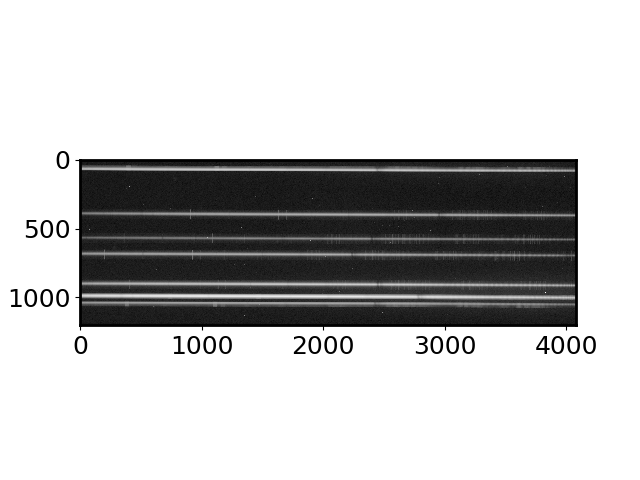

(717, 12886)

In [582]:

fig_poly1 = plt.figure()
ax_poly1 = fig_poly1.add_subplot(111)

imgt = rearr_ori_data#new_hdu_ori[3].data
ori_norm = simple_norm(imgt, stretch='log')
aspect_ratio = imgt.shape[1] / (3. * imgt.shape[0])
img_poly1 = ax_poly1.imshow(imgt, cmap='gray', interpolation='none',aspect=aspect_ratio,
                            norm=ori_norm)

imgt.min(),ori_norm.vmax

In [158]:


x,y = slice_rectangle.xy
w = slice_rectangle.get_width() 
h = slice_rectangle.get_height() 



slice_er_y, slice_er_x = np.mgrid[y:y+h, x:x+w]
extract_slice = fri_ccd.data[slice_er_y, slice_er_x]
extract_slice_shape = extract_slice.shape
slice_xpix = np.arange(h)#np.arange(extract_slice_shape[0])

coadded = slice_coadd(x,w,fri_ccd.data.shape[1],fri_ccd.data)
dp = np.gradient(np.gradient(coadded))

coaddeds = []
gradients = []
for slc in slice_cols:
    coadd = slice_coadd(slc,w,fri_ccd.shape[1],fri_ccd.data)
    grad = np.gradient(np.gradient(coadd))
    
    coaddeds.append(coadd)
    gradients.append(grad)
    


slice_cols

[1020, 2040, 3060, 3876]

In [159]:
def get_first_guess_edges(coadds_list,lower_lim_row=200,lower_lim_slit_height=5):
    
    ccd_sections_slit_pairs = []
    
    for coadd in coadds_list:
        
        #dprime = np.gradient(np.gradient(coadd))
        dprime = gaussian_filter1d(coadd, sigma=4)
        
        big_peaks = []
        last_big_peak_row = None
        slit_pairs = []
        slit_pair = []


        for y in range(len(dprime)-1):

            # take largest inflection point
            
            if dprime[y]>100 and y>lower_lim_row:

                if last_big_peak_row is None:
                    last_big_peak_row = y
                    slit_pair = [y]
                    big_peaks.append(y)
                elif np.abs(y-last_big_peak_row)>lower_lim_slit_height:
                    last_big_peak_row = y
                    big_peaks.append(y)

                    if len(slit_pair)<2:
                        slit_pair.append(y)
                    if len(slit_pair)==2:
                        slit_pairs.append(slit_pair)
                        slit_pair = []
        
        ccd_sections_slit_pairs.append(slit_pairs)
        
    return ccd_sections_slit_pairs

ccd_sections_slit_pairs = get_first_guess_edges(coadds_list=coaddeds,lower_lim_slit_height=20)

ccd_sections_slit_pairs

[[[201, 222],
  [243, 264],
  [285, 306],
  [327, 348],
  [369, 390],
  [411, 432],
  [453, 474],
  [495, 516],
  [537, 558],
  [579, 600],
  [621, 642],
  [663, 684],
  [705, 726],
  [747, 768],
  [789, 810],
  [831, 852],
  [873, 894],
  [915, 936],
  [957, 978],
  [999, 1020],
  [1041, 1062],
  [1083, 1104],
  [1125, 1146],
  [1167, 1188]],
 [[201, 222],
  [243, 264],
  [285, 306],
  [327, 348],
  [369, 390],
  [411, 432],
  [453, 474],
  [495, 516],
  [537, 558],
  [579, 600],
  [621, 642],
  [663, 684],
  [705, 726],
  [747, 768],
  [789, 810],
  [831, 852],
  [873, 894],
  [915, 936],
  [957, 978],
  [999, 1020],
  [1041, 1062],
  [1083, 1104],
  [1125, 1146],
  [1167, 1188]],
 [[201, 222],
  [243, 264],
  [285, 306],
  [327, 348],
  [369, 390],
  [411, 432],
  [453, 474],
  [495, 516],
  [537, 558],
  [579, 600],
  [621, 642],
  [663, 684],
  [705, 726],
  [747, 768],
  [789, 810],
  [831, 852],
  [873, 894],
  [915, 936],
  [957, 978],
  [999, 1020],
  [1041, 1062],
  [1083, 11

In [160]:


dp = gaussian_filter1d(gradients[-1],sigma=4)

print(np.abs(dp).mean(),np.median(dp))
dp_df = pd.DataFrame(dp,columns=['dp'])


sorted_dp_df = dp_df.sort_values(by='dp',ascending=False)

upper_dp_df = dp_df.where(dp_df.dp>0).dropna(how='all')
lower_dp_df = dp_df.where(dp_df.dp<0).dropna(how='all')

sorted_upper_dp_df = upper_dp_df.sort_values(by='dp',ascending=False)
sorted_lower_dp_df = lower_dp_df.sort_values(by='dp',ascending=True)

sorted_upper_dp_df

37.81832811775456 0.05569660017064487


,dp
50,488.725583
94,488.723919
93,481.282822
49,472.981189
1078,451.254988
...,...
151,0.000769
469,0.000701
275,0.000652
305,0.000497


In [161]:
sorted_lower_dp_df

,dp
58,-493.313958
85,-490.016728
59,-477.671519
86,-475.225817
84,-452.883696
57,-450.916916
1070,-446.301385
1043,-444.308908
1042,-442.579442
1069,-440.751374


<IPython.core.display.Javascript object>


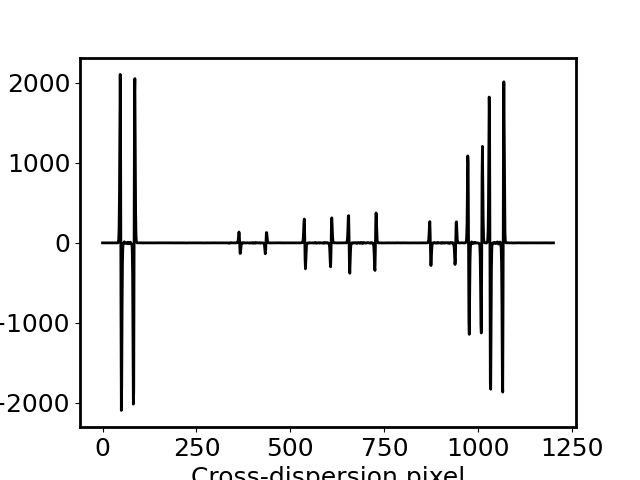

Text(0, 0.5, 'Coadded signal')

In [162]:

slice_1 = smooth = gaussian_filter1d(coaddeds[0], sigma=1)
slice_xpix = slice_xpix

dp_slice = np.gradient(np.gradient(slice_1))

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)


lin_raw, = ax2.plot(slice_xpix, dp_slice, 'k-')
ax2.set_xlabel('Cross-dispersion pixel')
ax2.axes.set_ylabel('Coadded signal')

#ax2.plot(dp,color='cyan')
#ax2.axhline(np.median(slice_1),ls='--')
#ax2.set_ylim(0,100)


In [163]:

pks = scipy.signal.find_peaks(dp_slice,height=np.sqrt(var))
dp_slice_df = pd.DataFrame(data=dp_slice,columns=['dpslice'])

pks

(array([  47,   86,  363,  436,  537,  610,  655,  728,  871,  942,  972,
        1011, 1029, 1068]),
 {'peak_heights': array([2104.8591023 , 2052.27626129,  135.83030117,  128.86991791,
          298.3683521 ,  312.97639773,  341.25894304,  374.2780373 ,
          266.1118614 ,  263.28696371, 1086.91689753, 1205.48910418,
         1822.06364288, 2012.41015766])})

In [24]:

pair_diffs = []
pair_inds = []
abs_pair_diffs = []
for i in dp_slice_df.index[:-1]:
    
    diff = np.subtract(dp_slice_df.loc[i,'dpslice'],dp_slice_df.loc[i+1,'dpslice'])
    inds_pair = [i, i+1]
    
    pair_diffs.append(diff)
    abs_pair_diffs.append(np.abs(diff))
    pair_inds.append(inds_pair)
    
pair_diffs.append(0)
abs_pair_diffs.append(0)
pair_inds.append([len(dp_slice_df),len(dp_slice_df)])


dp_slice_df['pair_diff'] = np.asarray(pair_diffs)
dp_slice_df['abs_pair_diff'] = np.asarray(abs_pair_diffs)
#dp_slice_df['diff_pair_inds'] = np.asarray(pair_inds)


dp_slice_df.sort_values(by='abs_pair_diff', ascending=False)[:500]

,dpslice,pair_diff,abs_pair_diff
2,23.929854,10.836282,10.836282
447,6.788554,10.635865,10.635865
3,13.093572,10.437878,10.437878
1465,-2.724705,-9.749492,9.749492
483,-0.007369,-9.412572,9.412572
482,-9.352411,-9.345042,9.345042
1429,7.658787,8.772840,8.772840
0,9.807300,-8.385140,8.385140
1430,-1.114053,7.999488,7.999488
448,-3.847311,6.960592,6.960592


In [25]:


big_peaks = []
last_big_peak_col = None
slit_pairs = []
slit_pair = []
for p in range(len(dp)-1):
    
    
    if dp[p]>100 and p>400:
        
        if last_big_peak_col is None:
            last_big_peak_col = p
            slit_pair = [p]
            big_peaks.append(p)
        elif np.abs(p-last_big_peak_col)>5:
            last_big_peak_col = p
            big_peaks.append(p)
            
            if len(slit_pair)<2:
                slit_pair.append(p)
            if len(slit_pair)==2:
                slit_pairs.append(slit_pair)
                slit_pair = []
            
            

            
slit_refs_file_name = 'slit_refs_test.txt'
slit_refs_file = open(slit_refs_file_name, "w")

slit_refs_header_comment = "# file written using" + "\n" + \
     "# 'PIPELINE.SAMOS_mods.identify_slits_from_nothing function" + "\n" + \
     "# first column is the row pixel for the top of each slit, and the second column is the slit height. \n"


slit_refs_file.write(slit_refs_header_comment)

for pair in slit_pairs:

    slit_height = np.diff(pair)
    print(slit_height[0])
    row_txt = "%s,%s\n"%(pair[0],slit_height[0])
    slit_refs_file.write(row_txt)

slit_refs_file.close()
            
slit_pairs,np.diff(slit_pairs)

([], array([], dtype=float64))

In [16]:
import PIPELINE.SAMOS_mods
importlib.reload(PIPELINE.SAMOS_mods)
from PIPELINE.SAMOS_mods import identify_slits




xedges, yedges = identify_slits(fri_ccd,slit_reference_file=slit_refs_file_name)

slit_refs = np.genfromtxt(slit_refs_file_name,unpack=True,delimiter=',') 
approx_edges = slit_refs[0]
approx_slit_height = np.asarray(slit_refs[1])

slice_er_ys, slice_er_xs = [],[]
extract_slices = []
for sl in range(len(yedges)):
    
    y0 = int(yedges[sl,0])
    y1 = int(yedges[sl,-1])
    print(y0,y1)
    y1b = y1-int(approx_slit_height[sl])
    h = np.subtract(y0,y1b)
    print(h,y1b,approx_slit_height[sl])
    x = int(xedges[sl,0])
    w = np.subtract(xedges[sl,-1],x)
    slice_er_y, slice_er_x = np.mgrid[y0:y0+h, x:x+w]
    extract_slice = fri_ccd.data[slice_er_y, slice_er_x]
    extract_slices.append(extract_slice)
    print(extract_slice.shape)

    


slit_refs_test.txt
386 352
74 312 40.0
(74, 4141)
727 705
96 631 74.0
(96, 4141)
893 879
88 805 74.0
(88, 4141)
1006 1029
51 955 74.0
(51, 4141)
1221 1198
94 1127 71.0
(94, 4141)
1339 1348
31 1308 40.0
(31, 4141)
1408 1418
31 1377 41.0
(31, 4141)


In [22]:


ccd = fri_ccd

xedges, yedges = identify_slits(ccd,slit_reference_file=slit_refs_file_name)

slit_refs = np.genfromtxt(slit_refs_file_name,unpack=True,delimiter=',') 
approx_edges = slit_refs[0]
approx_slit_height = np.asarray(slit_refs[1])

slice_er_ys, slice_er_xs = [],[]
sz = ccd.shape
N_pixel_x = sz[1]
N_pixel_y = sz[0]
print("number of cols: %f"%N_pixel_x)
print("number of rows: %f"%N_pixel_y)

x_axis = np.linspace(0,N_pixel_x-1,num=N_pixel_x,dtype=int)
y_axis = np.linspace(0,N_pixel_y-1,num=N_pixel_y,dtype=int)
pixel_x = np.zeros((N_pixel_y,N_pixel_x),dtype=int)


for row in range(N_pixel_y):
    for col in range(N_pixel_x):
        pixel_x[row,col] = col

pixel_y = np.zeros((N_pixel_y,N_pixel_x),dtype=int)
for row in range(N_pixel_y):
    for col in range(N_pixel_x):
        pixel_y[row,col] = row


cutout_slit_arrays_full = []
new_y_edges = np.empty_like(yedges)


slit_refs_test.txt
number of cols: 4142.000000
number of rows: 1896.000000


<IPython.core.display.Javascript object>


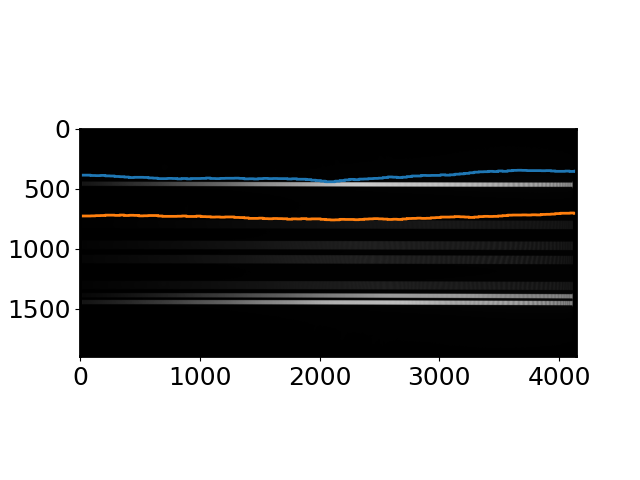

In [23]:
fig_full = plt.figure()
ax_full = fig_full.add_subplot(111)

ax_full.imshow(ccd,cmap='gray')

ax_full.plot(xedges[0],yedges[0])
ax_full.plot(xedges[1],yedges[1])

In [24]:
rotated_img = rotate(extract_slices[2],angle=0)
extraction_region = rotated_img #extract_slices[2]


er_ny, er_nx = extraction_region.shape



aspect_ratio = er_nx / (3. * er_ny)

er_norm = simple_norm(extraction_region, stretch='log')


fig_sl = plt.figure(figsize=(8,8))
img_sl = plt.imshow(extraction_region, cmap='gray',origin='lower',
                    aspect=aspect_ratio,norm=er_norm, interpolation='none')
clb_sl = plt.colorbar(orientation='horizontal')

sl_line = -xedges[2]*result.slope+43 #np.tan(angle)

plt.plot(xedges[2],sl_line)



NameError: name 'rotate' is not defined

In [ ]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)

ax3.plot(coadded)

#ax3.axvline(big_peaks[0],color='k')

for v in slit_pairs:
    
    ax3.axvline(v[0],ls='--',color='k',lw=1.5)
    ax3.axvline(v[1],ls='--',color='k',lw=1.5)
#ax3.set_ylim(0.1,10)
ax3.set_xlim(0,1600)

In [ ]:
big_peaks,len(big_peaks)